## Data Acquisition and Preparation

### §1. Data Import 

In [1]:
#Importing all the required
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score
import seaborn as sns

In [2]:
#importing the penguin dataset as a pandas DataFrame called penguins
url = 'https://philchodrow.github.io/PIC16A/datasets/palmer_penguins.csv'
penguins = pd.read_csv(url)

In [3]:
#displaying the first five rows of the penguins dataset
penguins.head()

,studyName,Sample Number,Species,Region,Island,Stage,Individual ID,Clutch Completion,Date Egg,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Body Mass (g),Sex,Delta 15 N (o/oo),Delta 13 C (o/oo),Comments
0,PAL0708,1,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N1A1,Yes,11/11/07,39.1,18.7,181.0,3750.0,MALE,NaN,NaN,Not enough blood for isotopes.
1,PAL0708,2,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N1A2,Yes,11/11/07,39.5,17.4,186.0,3800.0,FEMALE,8.94956,-24.69454,NaN
2,PAL0708,3,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N2A1,Yes,11/16/07,40.3,18.0,195.0,3250.0,FEMALE,8.36821,-25.33302,NaN
3,PAL0708,4,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N2A2,Yes,11/16/07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Adult not sampled.
4,PAL0708,5,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N3A1,Yes,11/16/07,36.7,19.3,193.0,3450.0,FEMALE,8.76651,-25.32426,NaN


### §2. Data Splitting

To aid us in our data exploration and model building, we can split our penguins dataset into training and test data sets. Splitting the data allows us to holdout some data (test data) which the model will not be able to see at first, which can later be used to test the accuracy of the model.

In [4]:
#Setting the seed to 1234 to ensure reproducibility
np.random.seed(1234)

# Splitting and holding out 20% of data as test dataset
train, test = train_test_split(penguins, test_size = 0.2) 

### §3. Data Cleaning

We clean the given dataset to allow for easier data exploration and analysis. We shorten the species name, remove rows wherein the sex of a penguin is entered as '.' in place of an actual gender. We also drop columns from the dataset which will not have an impact of predicting the species of the penguin, such as studyName, Sample Number, Individual ID, Clutch Completion, Date Egg, and Comments. Region was also dropped as it was constant across all penguin species.

In [5]:
#shortens the species name
penguins["Species"] = penguins["Species"].str.split().str.get(0)
    
#removes rows where Sex is .
penguins = penguins[penguins['Sex'] != '.']

#drops the columns which will not have an impact on the model
penguins = penguins.drop(['studyName', 'Sample Number', 'Region', 'Stage', 'Individual ID', 'Clutch Completion',
                          'Date Egg', 'Comments'],axis=1)

In [6]:
#displaying the first five columns of this cleaned penguins data set
penguins.head()

,Species,Island,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Body Mass (g),Sex,Delta 15 N (o/oo),Delta 13 C (o/oo)
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,MALE,NaN,NaN
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,FEMALE,8.94956,-24.69454
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,FEMALE,8.36821,-25.33302
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,FEMALE,8.76651,-25.32426


In [7]:
def prep_data(data_df):
    
    """
    A function that cleans the data in a given data frame and splits it into a target and predictor set
    
    Args:
        data_df: a DataFrame
        
    Returns:
        X: the values of the DataFrame in which the Sex column has been changed from MALE and FEMALE to 0s and 1s, and
        from which the Species column has been dropped
        y: the values of the DataFrame consisting of only the Species column
    """
    
    #creates a copy of the DataFrame
    df = data_df.copy()
    
    le = preprocessing.LabelEncoder()
    
    #drops all the NaN values
    df = df[["Culmen Length (mm)","Culmen Depth (mm)","Sex","Island","Species", "Body Mass (g)", "Flipper Length (mm)", 
             "Delta 15 N (o/oo)", "Delta 13 C (o/oo)"]].dropna()
    
    #encodes the column Sex, Species, and Island as integers
    df['Sex'] = le.fit_transform(df['Sex'])
    df['Species'] = le.fit_transform(df['Species'])
    df['Island'] = le.fit_transform(df['Island'])
    
    df_copy = df.copy()
    
    #dividing our data into predictor and target datasets
    X = df.drop(['Species'], axis = 1)
    y = df['Species']
    
    return(X, y, df_copy)

In [8]:
X,y,df_copy = prep_data(penguins)
X_train, y_train, cleaned_train = prep_data(train)
X_test,  y_test, clean_test  = prep_data(test)

## Exploratory Analysis

To help us visualise the relationship between the species of the penguins and other recorded features, we can construct a summary table. This summary table will showcase the median values of the different features for the penguins, grouped by Species, then Sex, and then Island. 

In [9]:
def summary_table (df, groups):
    """
    Docstring
    """
    values = df.copy()
    values = values.drop(groups, axis=1).columns.values
    summary_table = penguins.groupby(groups)[values].median()
    return summary_table

In [10]:
summary_table(penguins, ["Species", "Sex", "Island"])

Culmen Length (mm)  Culmen Depth (mm)  \
Species   Sex    Island                                             
Adelie    FEMALE Biscoe                  37.75              17.70   
                 Dream                   36.80              17.80   
                 Torgersen               37.60              17.45   
          MALE   Biscoe                  40.80              18.90   
                 Dream                   40.25              18.65   
                 Torgersen               41.10              19.20   
Chinstrap FEMALE Dream                   46.30              17.65   
          MALE   Dream                   50.95              19.30   
Gentoo    FEMALE Biscoe                  45.50              14.25   
          MALE   Biscoe                  49.50              15.70   

                            Flipper Length (mm)  Body Mass (g)  \
Species   Sex    Island                                          
Adelie    FEMALE Biscoe                   187.0         3375.0   
                 Dream                    188.0         3400.0   
                 Torgersen                189.0         3400.0   
          MALE   Biscoe                   191.0         4000.0   
                 Dream                    190.5         3987.5   
                 Torgersen                195.0         4000.0   
Chinstrap FEMALE Dream                    192.0         3550.0   
          MALE   Dream                    200.5         3950.0   
Gentoo    FEMALE Biscoe                   212.0         4700.0   
          MALE   Biscoe                   221.0         5500.0   

                            Delta 15 N (o/oo)  Delta 13 C (o/oo)  
Species   Sex    Island                                           
Adelie    FEMALE Biscoe              8.755420         -26.094190  
                 Dream               8.934650         -25.830600  
                 Torgersen           8.791595         -25.835025  
          MALE   Biscoe              8.828740         -25.942600  
                 Dream               8.975330         -26.015490  
                 Torgersen           8.900020         -26.024500  
Chinstrap FEMALE Dream               9.352770         -24.587305  
          MALE   Dream               9.458270         -24.555925  
Gentoo    FEMALE Biscoe              8.208700         -26.210945  
          MALE   Biscoe              8.289135         -26.251185

From the above table, we can see that male and female populations were observed across all species.  Interestingly, Adelie penguins were found on all three islands: Biscoe, Dream, and Torgersen. Chinstrap Penguins were found only on the Dream island, while Gentoo penguins were found only on Biscoe island. This indicates that the qualitative feature of Island could be a better feature to include in our model compared to the qualitative feature of Sex. 

Adelie Penguins had the shortest culmen, with the culmen length of the femeales being the shortest, while Chinstrap penguins had the longest culmen. In terms of culmen depth, Gentoo penguins had the least depth while Chinstrap penguins had the greatest. When it comes to flipper length, Adelie penguins had the shortest flippers, while Gentoo penguins had the longest ones.  Gentoo penguins had the greatest body mass, while that of Adelie and Chinstrap were relatively the same. No interesting trends could be observed in the two delat features. This points to the first four features of culmen length, culmen depth, flipper length, and body mass being the stronger quantitative features which could be included in our model. 

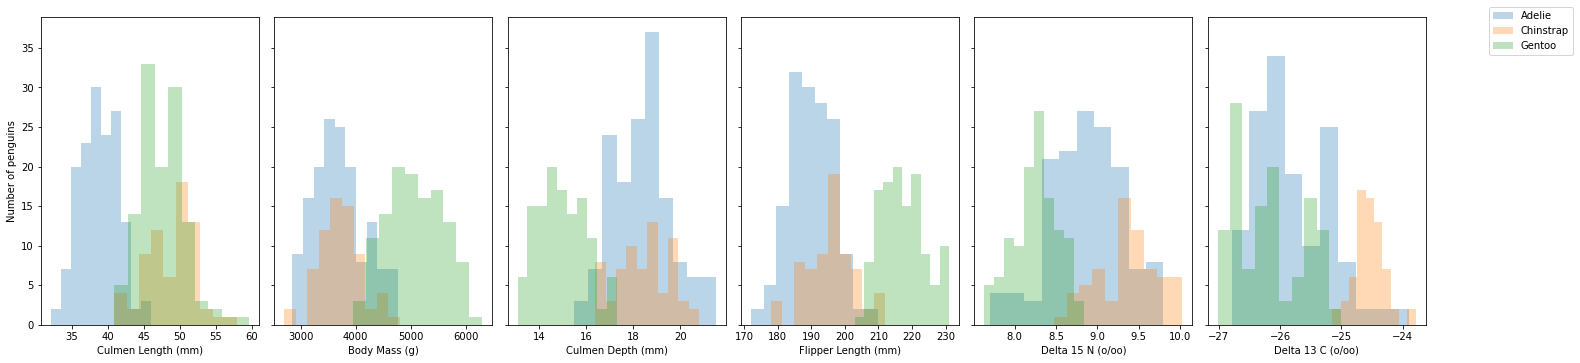

In [11]:
fig, ax = plt.subplots(1,6, figsize = (20,5), sharey = True)
ax[0].set(ylabel = "Number of penguins")
data = ["Culmen Length (mm)", "Body Mass (g)", 
            "Culmen Depth (mm)","Flipper Length (mm)", "Delta 15 N (o/oo)","Delta 13 C (o/oo)"]
unique_species = penguins["Species"].unique()

for i in range(len(data)):
    for j in unique_species:
        df = penguins[penguins["Species"] == j]
        ax[i].hist(df[data[i]], label = j, alpha = 0.3)
        ax[i].set(xlabel = data[i])
        
plt.tight_layout()
plt.legend(bbox_to_anchor=(1.7, 1.05))

From the above histogram, we can see number of penguins for each features. There are some notable features by looking at this histogram. For `Culmen Length (mm)`, Gentoo penguin has notably higher than the other species. For `Culmen Depth (mm)` it's notable that Adelie penguins have the highest.

Other than that, we can see that Adelie penguins had the shortest culmen, Chrinstrap penguins had the longest culmen. Chinstrap had smaller in almost every features. This points to the first four features of culmen length, culmen depth, flipper length, and body mass being the stronger quantitative features which could be included in our model.

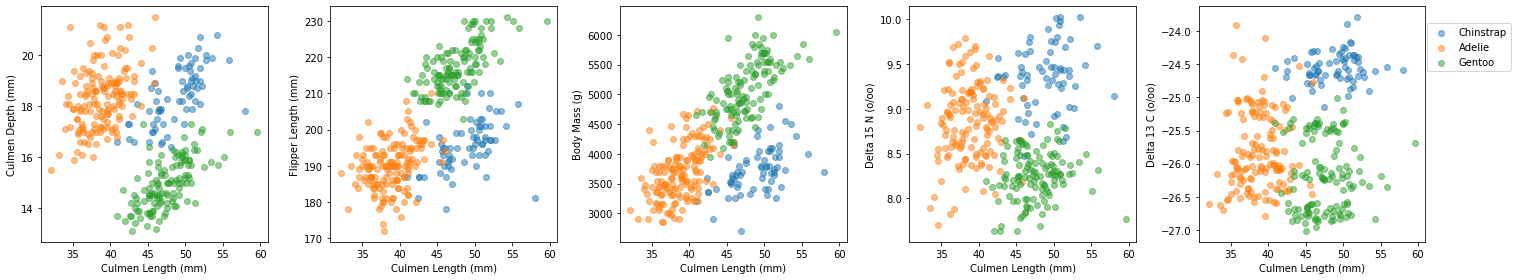

In [12]:
fig, ax = plt.subplots(1, 5, figsize = (20,4))
ax[0].set(xlabel = 'Culmen Length (mm)', ylabel = 'Culmen Depth (mm)')
ax[1].set(xlabel = 'Culmen Length (mm)', ylabel = 'Flipper Length (mm)')
ax[2].set(xlabel = 'Culmen Length (mm)', ylabel = 'Body Mass (g)')
ax[3].set(xlabel = 'Culmen Length (mm)', ylabel = 'Delta 15 N (o/oo)')
ax[4].set(xlabel = 'Culmen Length (mm)', ylabel = 'Delta 13 C (o/oo)')

species = set(penguins['Species'])

for s in species:
    sub = penguins[penguins['Species'] == s]
    ax[0].scatter(sub['Culmen Length (mm)'], sub['Culmen Depth (mm)'], label = s, alpha = 0.5)
    ax[1].scatter(sub['Culmen Length (mm)'], sub['Flipper Length (mm)'], label = s, alpha = 0.5)
    ax[2].scatter(sub['Culmen Length (mm)'], sub['Body Mass (g)'], label = s, alpha = 0.5)
    ax[3].scatter(sub['Culmen Length (mm)'], sub['Delta 15 N (o/oo)'], label = s, alpha = 0.5)
    ax[4].scatter(sub['Culmen Length (mm)'], sub['Delta 13 C (o/oo)'], label = s, alpha = 0.5)

plt.tight_layout()
plt.legend(bbox_to_anchor=(1.4, 0.95))

## *Explanation of scatterplots*

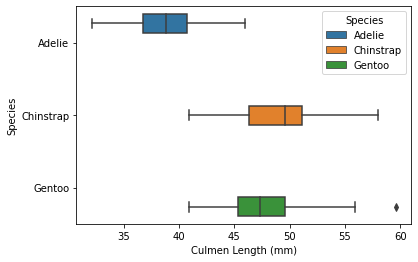

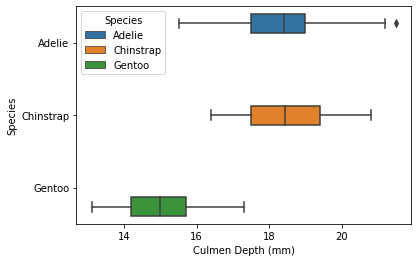

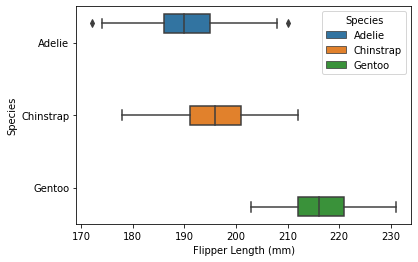

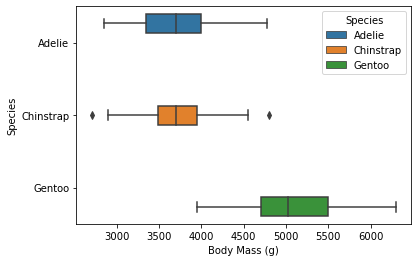

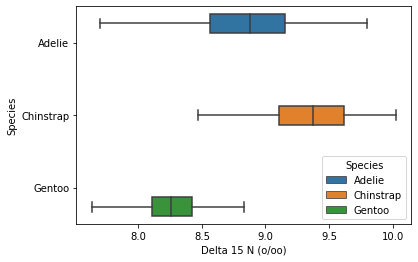

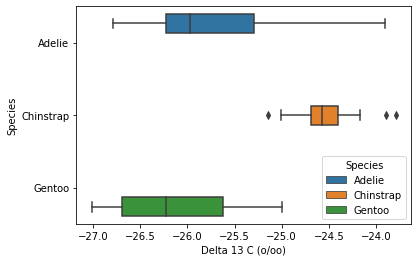

In [13]:
x_ax = penguins.copy()
x_ax = x_ax.drop(["Species","Sex","Island"], axis=1).columns.values
species = penguins["Species"].unique
    
for i in range(len(x_ax)):
#Using sns.boxplot to plot a boxplot of the gdpPerCap across continents 
    boxplot = sns.boxplot(x = x_ax[i],
                     y = "Species",
                     data = penguins,
                     hue = "Species")
    plt.show()

## *Explanation of boxplots*

# Feature Selection

To visualise the correlations between the different quantiative and qualitative features of the penguins dataset, we plot a correlation heatmap.

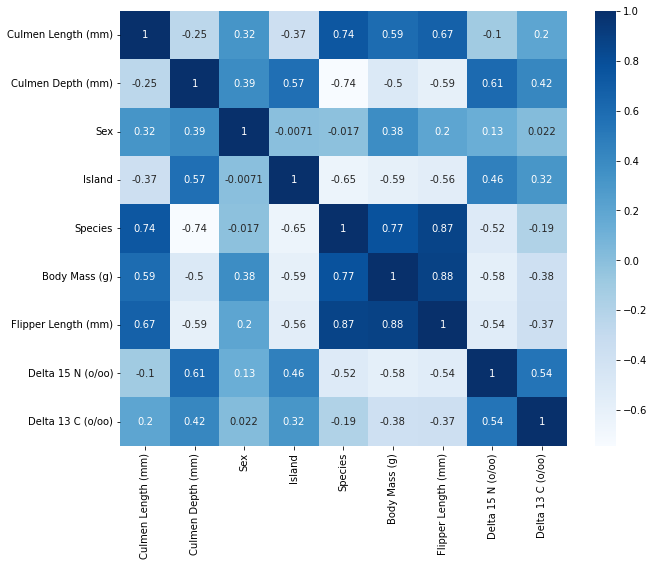

In [14]:
#plotting the heatmap
import seaborn as sns
plt.figure(figsize=(10,8))
cor = cleaned_train.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Blues)
plt.show()

In [15]:
#Correlation of quantitative and qualitative features with the target variable
corr_target = abs(cor["Species"])

#Visualising the features with the highest correlation
imp_features = corr_target[corr_target>0.5].sort_values(ascending=False)
imp_features

Species                1.000000
Flipper Length (mm)    0.867907
Body Mass (g)          0.773947
Culmen Depth (mm)      0.744324
Culmen Length (mm)     0.736564
Island                 0.647180
Delta 15 N (o/oo)      0.516752
Name: Species, dtype: float64

Based on the heatmap and the analysis done on it, the qualitative feature with the highest correlation coefficient to our target variable, Species is Island. The quantitative features with the highest correlation coefficients are Flipper Length (mm), Body Mass (g), Culmen Depth (mm), Delta 15 N (o/oo), and Culmen Length (mm). When inspecting the heat map of correlation coefficients, we observe that Culmen Length (mm) is least correlated to Island, so we pick Culmen Length (mm) to be our second feature. Among Culmen Depth (mm), Flipper Length (mm), Delta 15 N (o/oo), and Body Mass (g), Delta 15 N (o/oo) is least correlated to Culmen Length (mm), but it is very borderline, so we picked the next least correlated feature Culmen Depth (mm), to be our third feature.

The features we selected using the heatmap based on correlation coefficients supports the graphs in our exploratory analysis of the features. Our summary table showed us that Island is a better qualitative feature to use in our model than Sex. The scatter plot also supported that Culmen Depth (mm) should be one of our model's quantitative features because the species have more distinct points, but with Delta 15 N (o/oo), there are more overlapping points between species. The heatmap shows us that Culmen Depth (mm) is our third feature which corroborates the theory that our second quantitative feature should be Culmen Depth (mm), Flipper Length (mm), Delta 15 N (o/oo), or Body Mass (g), Delta 15 N (o/oo). The histograms and boxplots of the different features of penguins support our analysis for this heatmap plot.

Now that we have selected our features, we drop any NaN values in our data sets and drop the variables which we do not need so that we are left wth the predictor variables (X) of Culmen Length (mm), Culmen Depth (mm), and Island, and a target variable (y) of Species.

We also confirmed our choice of qualitative features using an exhaustive search. We first generated a list of the different combinations of 1 qualitative and 2 quantative features which could predict the species of penguin.

In [16]:
from itertools import combinations

#two lists combs1 and combs2 with different combinations of 2 quantitative features
combs1 = list(combinations(list(x_ax),2))
combs2 = list(combinations(list(x_ax),2))

#for loop to append the qualitative feature of Sex to the list of combinations of 2 quantative features
for i in range(len(combs1)):
    combs1[i]=list(combs1[i])
    combs1[i].append('Sex')

#for loop to append the qualitative feature of Island to the list of combinations of 2 quantative features
for i in range(len(combs2)):
    combs2[i]=list(combs2[i])
    combs2[i].append('Island')

#combining the 2 lists with different combinations of 1 qualitiative and 2 quantitative features
combs = combs1 + combs2

#displaying the different combinations of quantitative and qualitative features
combs

[['Culmen Length (mm)', 'Culmen Depth (mm)', 'Sex'],
 ['Culmen Length (mm)', 'Flipper Length (mm)', 'Sex'],
 ['Culmen Length (mm)', 'Body Mass (g)', 'Sex'],
 ['Culmen Length (mm)', 'Delta 15 N (o/oo)', 'Sex'],
 ['Culmen Length (mm)', 'Delta 13 C (o/oo)', 'Sex'],
 ['Culmen Depth (mm)', 'Flipper Length (mm)', 'Sex'],
 ['Culmen Depth (mm)', 'Body Mass (g)', 'Sex'],
 ['Culmen Depth (mm)', 'Delta 15 N (o/oo)', 'Sex'],
 ['Culmen Depth (mm)', 'Delta 13 C (o/oo)', 'Sex'],
 ['Flipper Length (mm)', 'Body Mass (g)', 'Sex'],
 ['Flipper Length (mm)', 'Delta 15 N (o/oo)', 'Sex'],
 ['Flipper Length (mm)', 'Delta 13 C (o/oo)', 'Sex'],
 ['Body Mass (g)', 'Delta 15 N (o/oo)', 'Sex'],
 ['Body Mass (g)', 'Delta 13 C (o/oo)', 'Sex'],
 ['Delta 15 N (o/oo)', 'Delta 13 C (o/oo)', 'Sex'],
 ['Culmen Length (mm)', 'Culmen Depth (mm)', 'Island'],
 ['Culmen Length (mm)', 'Flipper Length (mm)', 'Island'],
 ['Culmen Length (mm)', 'Body Mass (g)', 'Island'],
 ['Culmen Length (mm)', 'Delta 15 N (o/oo)', 'Island'],
 ['

In [17]:
def exhaustive_search(model, X, y, min_cols, max_cols):
    """
    A function that iterates through the list of quantitative and qualitative feature combinations and returns the 
    feature set with the best CV score.

    Args:
        model: the chosen machine learning model
        X: the cleaned penguins data set without the target column
        y: the target column from the cleaned penguins data set
        min_cols: the minimum number of features for the model
        max_cols: the maximum number of features for the model

    Returns:
        best_cv: the higher cv score
        best_cols: the combination of features with the highest cv score
    """
    #setting the best cv score to 0
    best_cv = 0
    
    #setting the best combination of features as None
    best_cols = None
    
    #for loop to iterate through the different feature combinations
    for n_cols in range(min_cols, max_cols + 1):
        for cols in combs:
            #assigns the cv score based on the combinations of features
            cv = cross_val_score(model, X[list(cols)], y, cv = 10).mean()
            #if statement to check if the cv score for the current feature combination is higher than prior 
            #combinations and reassign it to best_cv if so
            if cv > best_cv:
                best_cv = cv
                #assigns the features combination with the highest cv score to best_cols
                best_cols = cols    
    
    #returns the best features combination and best cv score
    return best_cv, best_cols

We then run the multinomial logistic regression model through the exhaustive search function to visualise the best combination of features along with its cv score.

In [18]:
from sklearn.linear_model import LogisticRegression
LR = LogisticRegression(solver = "liblinear", random_state=16)

best_cv, best_cols = exhaustive_search(LR, X, y, 3, 3)

In [19]:
best_cv, best_cols

(0.9628787878787879, ['Culmen Length (mm)', 'Culmen Depth (mm)', 'Island'])

The exhaustive search function returns 'Culmen Length (mm)', 'Culmen Depth (mm)', and 'Island' as the combination of 1 qualitative and 2 quantative features to predict the penguin species with the highest cv score of 0.963. This aligns with the inference we made based on our correlation heatmap as well. So, we choose these three features to be used across our three models. 

We then assign these finalised predictor variables to our X training and X test data set to be used in the 3 models. 

# Multinomial Logistic Regression Model
### §1. MLR modelling and cross validation

In [77]:
X_train1 = X_train[["Culmen Length (mm)","Culmen Depth (mm)", "Island"]]
X_test1 = X_test[["Culmen Length (mm)","Culmen Depth (mm)", "Island"]]
y_train1 = y_train
y_test1 = y_test

We use cross-validation to check the optimum hyperparameter value. In the case of the MLR model, this is C or the inverse regularisation. 

For C = 0.001 , the cv score is 0.803076923076923
For C = 0.01 , the cv score is 0.7992307692307692
For C = 0.1 , the cv score is 0.9152307692307691
For C = 1 , the cv score is 0.9726153846153848
For C = 10 , the cv score is 0.9806153846153848


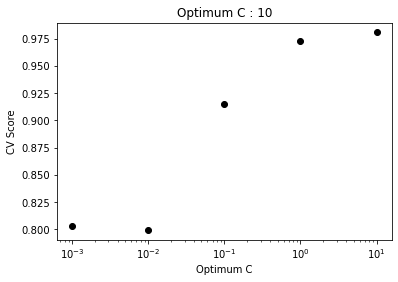

In [21]:
fig, ax = plt.subplots(1)

best_score = 0

params = [0.001, 0.01, 0.1, 1, 10]

for c in params:
    LR = LogisticRegression(solver = "liblinear", random_state=16, C = c)
    cv_score = cross_val_score(LR, X_train1, y_train1, cv=10).mean()
    print ("For C = " + str(c) + " , the cv score is " + str(cv_score))
    
    ax.scatter(c, cv_score, color = "black")
    if cv_score > best_score:
        best_C = c
        best_score = cv_score

l = ax.set(title = "Optimum C : " + str(best_C),
       xlabel = "Optimum C", 
       ylabel = "CV Score")

plt.xscale("log")

From the above plot, we see the highest cv score is achieved with C = 10. However, the different between C=10 and C=1, the next highest cv score, is quite minute, a difference of around 0.008. So, we choose C=1 to prevent overfitting of the model. 

We create the Multinomial Logistic Regression model and assign it to LR with C=1.

In [22]:
LR = LogisticRegression(solver = "liblinear", random_state=16, C=1)

We calculate the cv scores for the model to understand the accuracy of the MLR model.

In [23]:
#calculating the cv scores for the MLR model
cv_scores = cross_val_score(LR, X_train1, y_train1, cv=10)

print("The mean cross-validation score is "+ str(cv_scores.mean())+ ".")
print("The standard deviation of the cross-validation score is "+ str(cv_scores.std())+ ".")

The mean cross-validation score is 0.9726153846153848.
The standard deviation of the cross-validation score is 0.03971972815533519.


For the MLR model, we get a mean cross-validation score of 0.973, with a standard deviation of 0.040. This implies that the MLR model has a high accuracy when it comes to predicting the species of penguins given our chosen features.

We train the MLR model on our training data set, based on the chosen features of Island, Culmen Length (mm), and Culmen Length (mm).

In [24]:
LR.fit(X_train1, y_train1)

LogisticRegression(C=1, random_state=16, solver='liblinear')

### §2. Evaluating model on test set

We also scored and evaluated our model against our test data set. 

In [25]:
print("Accuracy: "+ str(LR.score(X_test1, y_test1)))

Accuracy: 0.9393939393939394


On the test data set, the MLR model scores 0.939. This is a relatively high accuracy score and suggests that the MLR model fits the test data well.

### §3. Confusion matrix

To gain a better understanding of the accuracy of the MLR model and where it went wrong, we can use the confusion matrix. First, we look at the predictions made by the model of the penguin species based on the chosen features in the test set. 

In [26]:
#assigns predictions of penguin species based on the MLR model on the test set of the predictor variables
y_pred1 = LR.predict(X_test1)
y_pred1

array([0, 2, 0, 0, 0, 2, 2, 1, 0, 0, 0, 0, 0, 2, 2, 2, 1, 0, 0, 1, 2, 0,
       0, 0, 0, 0, 2, 0, 1, 0, 1, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 1,
       1, 2, 0, 2, 2, 2, 1, 0, 1, 0, 0, 1, 0, 2, 2, 0, 1, 2, 1, 2, 0, 2])

Then, we create and display a confusion matrix to see what our model predicts as the penguin species and what the penguin species actually is.

In [27]:
# import the metrics class
from sklearn import metrics

def conf_matrix (y_test, y_pred):
    """
    Function that calculates and displays the confusion matrix for a given model.
    
    Args:
        y_test: the test data set with the penguin species
        y_pred: the predictor set with the penguin species
        
    Returns:
        None (displays the dataFrame with the confusion matrix)
    """
    #creates and assigns the confusion matrix to a pandas dataframe based on the predicted and actual penguin species
    cm = pd.DataFrame(metrics.confusion_matrix(y_test, y_pred),
                    index = ['Actual ' + i for i in np.unique(penguins['Species'])],
                    columns = ['Predicted ' + i for i in np.unique(penguins['Species'])])
    #prints confusion matrix
    print('Confusion Matrix:')
    
    #displays the confusion matrix dataFrame
    display(cm)

conf_matrix (y_test1, y_pred1)

Confusion Matrix:


,Predicted Adelie,Predicted Chinstrap,Predicted Gentoo
Actual Adelie,30,0,0
Actual Chinstrap,3,12,1
Actual Gentoo,0,0,20


Based on the above confusion matrix, we can see that most of the time, the MLR model predicts the penguin species correctly. However, we do have instances where the model incorrectly classified the penguins. In the above dataframe, the second row represented the number of penguins that are actually of the Chinstrap species. This row highlights that 3 penguins that are actually Chinstrap were predicted to be of the Adelie species and 1 was predicted to be Gentoo, while the remaining 12 penguins were correctly predicted to be Chinstrap.

### §4. Decision regions

In [73]:
from matplotlib import patches as mpatches

def decision_regions(model,X_test, y_test):
# plot the decision regions of the classifier

    fig, ax = plt.subplots(3, figsize = (12,20), sharey = True)
    
    uniqueQualValues = [int(i) for i in np.unique(X_test["Island"])] # as list of integers

# create a meshgrid of the dataset
    f1_min, f1_max = X["Culmen Length (mm)"].min() - 1, X["Culmen Length (mm)"].max() + 1
    f2_min, f2_max = X["Culmen Depth (mm)"].min() - 1, X["Culmen Depth (mm)"].max() + 1
    f1, f2 = np.meshgrid(np.arange(f1_min, f1_max, 0.1), np.arange(f2_min, f2_max, 0.1))

    for i in uniqueQualValues:
    # predict the class of each point in the meshgrid
        Z = model.predict(np.c_[f1.ravel(), f2.ravel(), np.ones(f1.ravel().shape) * 1.0 * i])
        Z = Z.reshape(f1.shape)

        color={
            "Adelie":"red",
            "Chinstrap":"green",
            "Gentoo":"blue"
        }
        
        ax[i].scatter(X_test[X_test["Island"]==i]["Culmen Length (mm)"], X_test[X_test["Island"]==i]["Culmen Depth (mm)"], 
                     c=y_test[X_test["Island"]==i], cmap='jet', vmin = 0, vmax = 2) # plot the test set samples as a scatter plot


        ax[i].contourf(f1, f2, Z, alpha=0.2, cmap="jet") # plot the decision regions
    
        ax[i].set_xlabel('Culmen Length (mm)')
        ax[i].set_ylabel('Culmen Depth (mm)')
    
    ax[0].set_title('Torgensen')
    ax[1].set_title('Dream')
    ax[2].set_title('Biscoe')


    legend0 = mpatches.Patch(color = 'red', label = 'Adelie', alpha = 0.2)
    legend1 = mpatches.Patch(color = 'green', label = 'Chinstrap', alpha = 0.2)
    legend2 = mpatches.Patch(color = 'blue', label = 'Gentoo', alpha = 0.2)
    fig.legend(handles = [legend0, legend1, legend2],loc = (0.9,0.92), fontsize = 'medium',framealpha = 1)


/Users/diyagopinath/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/Users/diyagopinath/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/Users/diyagopinath/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


Text(0.5, 0.98, 'Decision Regions of the Multinomial Logistic Regression: Test Set')

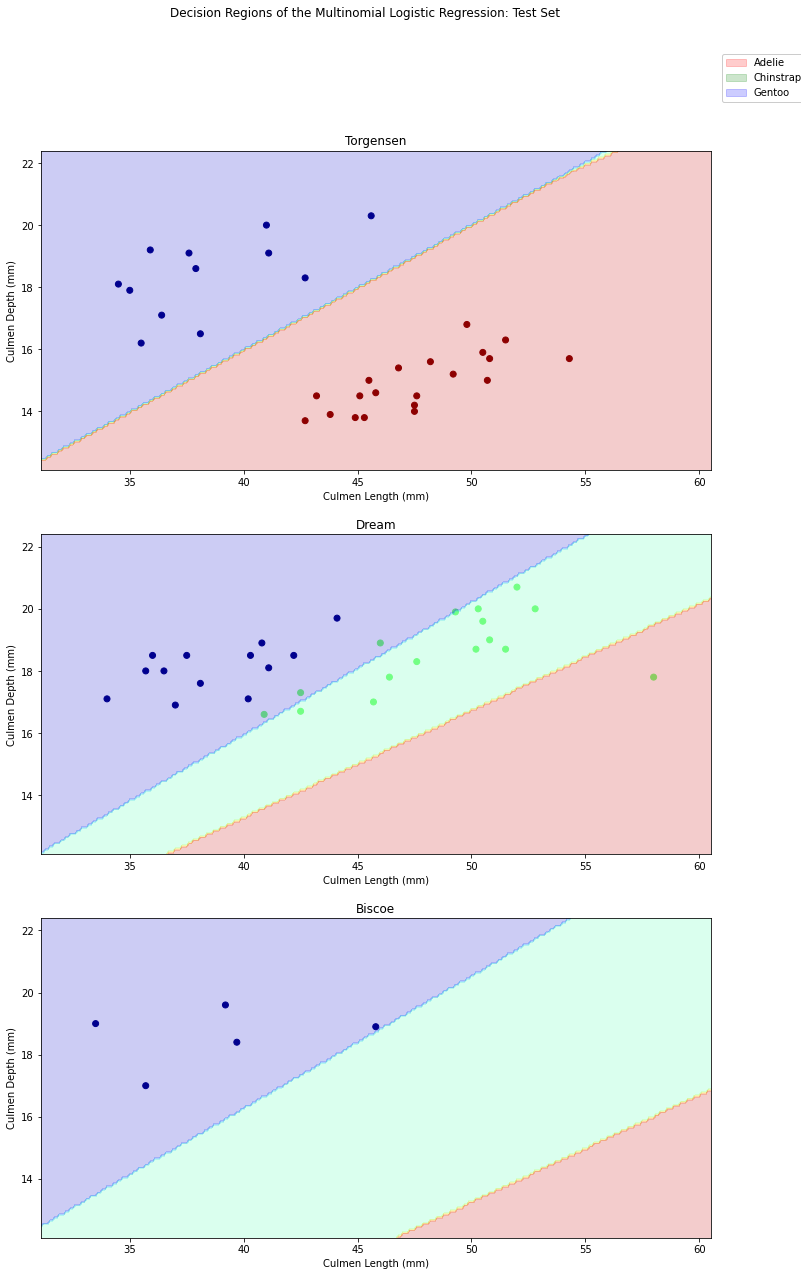

In [29]:
decision_regions(LR,X,y,X_test1, y_test1)
plt.suptitle('Decision Regions of the Multinomial Logistic Regression: Test Set')

## Neighbors Classifier Model
### §1. Neighbor Classifier modelling and cross validation

In [30]:
X_train2 = X_train[["Culmen Length (mm)","Culmen Depth (mm)", "Island"]]
X_test2 = X_test[["Culmen Length (mm)","Culmen Depth (mm)", "Island"]]
y_train2 = y_train
y_test2 = y_test

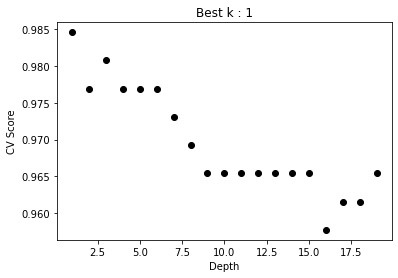

In [31]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

fig, ax = plt.subplots(1)

best_score = 0

for d in range(1,20):
    rf = KNeighborsClassifier(n_neighbors = d)
    cv_score = cross_val_score(rf, X_train2, y_train2, cv=5).mean()
    ax.scatter(d, cv_score, color = "black")
    if cv_score > best_score:
        best_depth = d
        best_score = cv_score

l = ax.set(title = "Best k : " + str(best_depth),
       xlabel = "Depth", 
       ylabel = "CV Score")

We create an instance of the KneighborsClassifier class and assign it to knn variable.

In [32]:
knn2 = KNeighborsClassifier(n_neighbors = 1)
cv_scores = cross_val_score(knn2, X_train2, y_train2, cv=10)

print("The mean cross-validation score is "+ str(cv_scores.mean())+ ".")

#Creating a dictionary of neighbours 
neighbours= {'n_neighbors': np.arange(1, 10)}
knn_cv = GridSearchCV(knn2, neighbours, cv=5)

#fit model to data
knn2.fit(X_train2, y_train2)

The mean cross-validation score is 0.9923076923076923.


KNeighborsClassifier(n_neighbors=1)

We create an instance of the KneighborsClassifier class and assign it to knn variable. This class requires a parameter named n_neighbors, which will be set to the K nearest neighbors algorithm. We use GridSearch CV to determine the best hyper parameter.

Here, we found out that from 1 to 10, 1 is the best k which has 0.98 accuracy. So we will be setting n_neighbors as 1.

### §2. Evaluating model on test set

In [33]:
from matplotlib.colors import ListedColormap
from sklearn import neighbors, datasets

In [34]:
print("Accuracy: "+ str(knn2.score(X_test2, y_test2)))

Accuracy: 0.9393939393939394


We also evaluated our model against our test data set. With our test data set we have a 0.94. This is close to our training data set which is a 0.98. 

### §3. Confusion Matrix

In [35]:
#assigns predictions of penguin species based on the MLR model on the test set of the predictor variables
y_pred2 = knn2.predict(X_test2)
y_pred2

array([0, 2, 0, 0, 0, 2, 2, 1, 0, 0, 0, 0, 0, 2, 2, 2, 1, 1, 0, 1, 2, 0,
       0, 0, 1, 1, 2, 0, 1, 0, 1, 2, 2, 1, 0, 2, 0, 0, 0, 0, 0, 2, 0, 1,
       1, 2, 0, 2, 2, 2, 1, 0, 1, 0, 0, 1, 0, 2, 2, 0, 1, 2, 1, 2, 0, 2])

In [74]:
conf_matrix (y_test2, y_pred2)

Confusion Matrix:


,Predicted Adelie,Predicted Chinstrap,Predicted Gentoo
Actual Adelie,28,2,0
Actual Chinstrap,1,14,1
Actual Gentoo,0,0,20


The confusion matrix shows that most of the time, the MLR model predicts the penguin species correctly. There are some wrong categorization.

### §4. Decision regions

/Users/diyagopinath/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/Users/diyagopinath/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/Users/diyagopinath/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


Text(0.5, 0.98, 'Decision Regions of the Neighbors Classifier Model: Test Set')

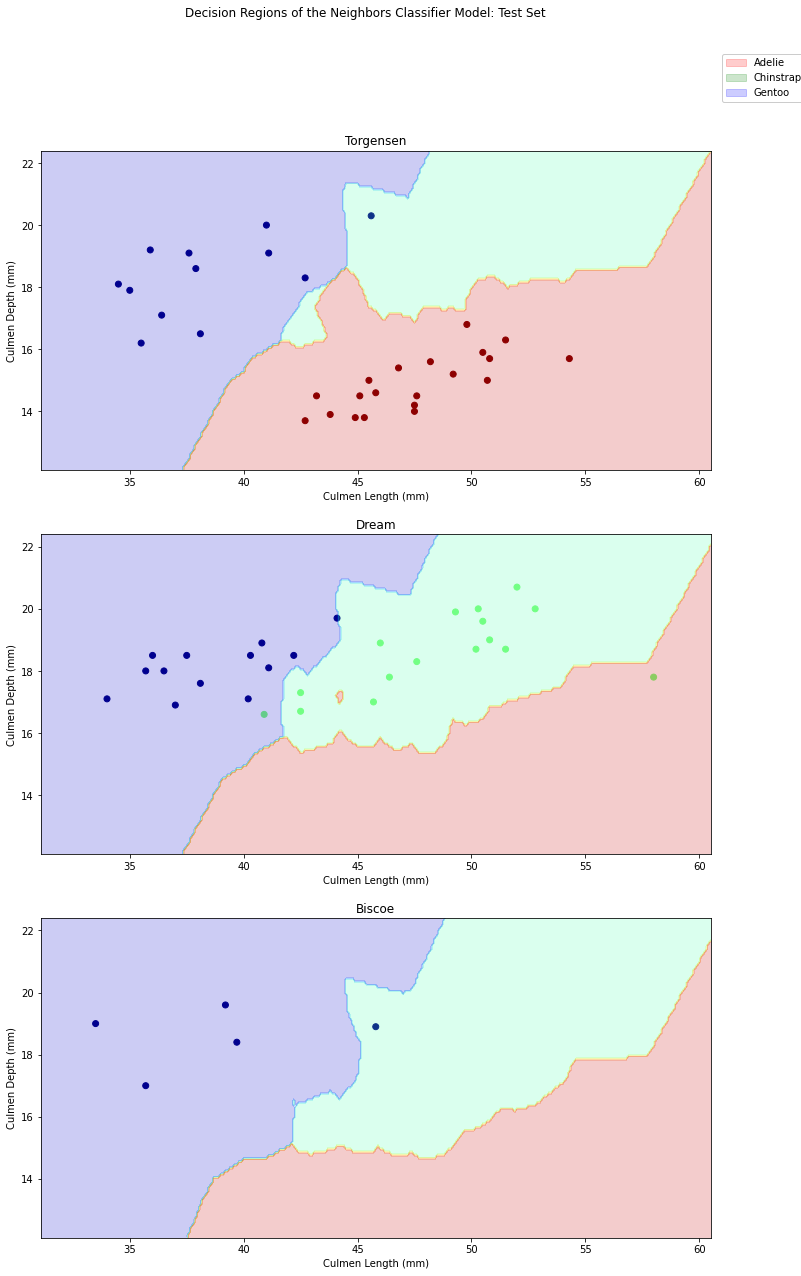

In [75]:
decision_regions(knn2,X_test2,y_test2)
plt.suptitle('Decision Regions of the Neighbors Classifier Model: Test Set')

# Random Forest Classifier Model

### §1. Random Forest modelling and cross validation

A random forest model is a classification model which uses several decision trees to increase the accuracy of the model's prediction and to prevent overfitting.

In [62]:
X_train3 = X_train[["Culmen Length (mm)","Culmen Depth (mm)", "Island"]]
X_test3 = X_test[["Culmen Length (mm)","Culmen Depth (mm)", "Island"]]
y_train3 = y_train
y_test3 = y_test

In [63]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
rf.fit(X_train3, y_train3)

RandomForestClassifier()

For the random forest model, I used Grid Search, because there are 2 important hyperparameters in a random forest classifier model, n_estimators: which is the number of trees, and max_depth: the number of splits a tree can have.

In [64]:
from sklearn.model_selection import GridSearchCV


param_grid = {
                 'n_estimators': [5, 10, 15, 20],
                 'max_depth': [2, 5, 7, 9]
             }

grid_rf = GridSearchCV(rf, param_grid, cv=10)
grid_rf.fit(X_train3, y_train3)

grid_rf.best_params_

{'max_depth': 5, 'n_estimators': 15}

In [65]:
grid_rf.best_score_

0.9923076923076923

The best cross validation score is 99.23%, showing us that these parameters are a good fit for the model.

In [66]:
# new model with hyperparameters from cross-validation
clf=RandomForestClassifier( max_depth=5, n_estimators = 15)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train3,y_train3)

### §2. Evaluating model on test set

In [68]:
# score of the model on the test set
print("Accuracy: "+ str(clf.score(X_test3, y_test3)))

Accuracy: 0.9545454545454546


We scored our model on the test, to get an accuracy of 95%.

### §3. Confusion Matrix

In [70]:
# prediction on test set
y_pred3=clf.predict(X_test3)
y_pred3

array([0, 2, 0, 0, 0, 2, 2, 1, 0, 0, 0, 0, 0, 2, 2, 1, 1, 2, 0, 1, 2, 0,
       0, 0, 1, 1, 2, 1, 1, 0, 1, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 1,
       1, 2, 0, 2, 2, 2, 1, 0, 1, 0, 0, 1, 0, 2, 2, 0, 1, 2, 1, 2, 0, 2])

In [71]:
conf_matrix (y_test3, y_pred3)

Confusion Matrix:


,Predicted Adelie,Predicted Chinstrap,Predicted Gentoo
Actual Adelie,28,1,1
Actual Chinstrap,1,15,0
Actual Gentoo,0,0,20


From the confusion matrix above, the model correctly predicts the species, most of the time. There are a few instances such as in row 1 and 2, where the model classified an Adelie penguin as a Chinstrap or a Gentoo, and once where it predicted a Chinstrap penguin as an Adelie.

### §4. Decision regions

/Users/diyagopinath/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/diyagopinath/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/diyagopinath/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Text(0.5, 0.98, 'Decision Regions of the Random Forest Classifier Model: Test Set')

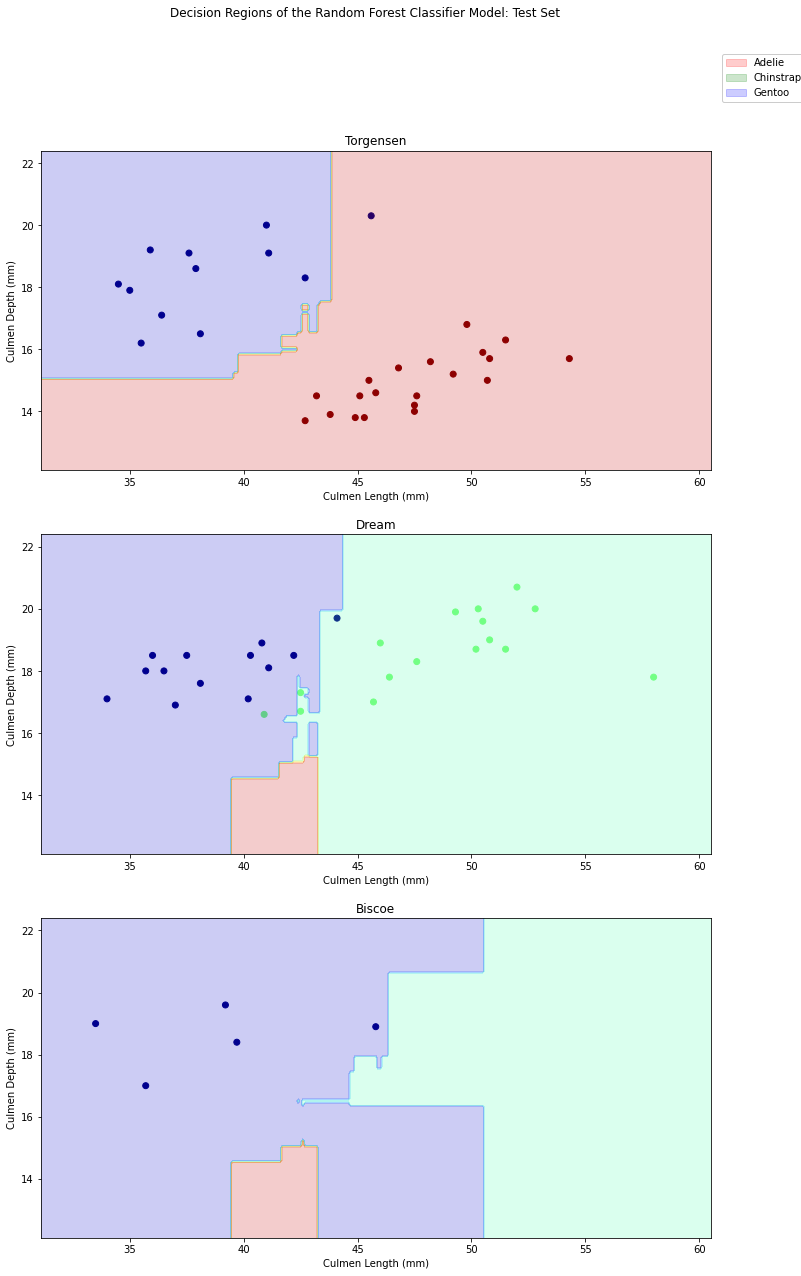

In [76]:
decision_regions(clf,X_test3,y_test3)
plt.suptitle('Decision Regions of the Random Forest Classifier Model: Test Set')

# Conclusion

Our final model to predict a penguin's species based on our experiment is Multinomial Logistic Regression Model model which examines Culmen Length (mm), Culmen Depth (mm) and Island features of a penguin. It showed a 95.5% accuracy rate, when Neighbors Classifier Model and Random Forest Classifier had a 94% accuracy rate.

These three models show how we can perform classification in machine learning. It trains data so that the model can identify which class or category a new data should fall into. We can improve our models' accuracy by accumulating and training more dataset. Also, we could experiment by using alternative values for the training parameters used with each algorithms. However, we still had a pretty high accuracy with 95% in average.